In [2]:
import pandas as pd
import re
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import gensim
from gensim import corpora
from gensim.models import LdaModel
import pyLDAvis.gensim_models
import pyLDAvis
import nltk

nltk.download('stopwords')
nltk.download('punkt')

df = pd.read_csv("dataset-train.csv", usecols=[3, 5], header=0)
test_df = pd.read_csv('dataset-test.csv', usecols=[4, 5], header=0)

df.columns = ['text', 'label']
test_df.columns = ['text', 'label']

# Set of English stopwords
english_stopwords = set(stopwords.words('english') + list(gensim.parsing.preprocessing.STOPWORDS))

# Function to preprocess text data
def preprocess(text):
    text = BeautifulSoup(text, features="html.parser").get_text()  # Decode HTML entities
    text = re.sub(r'[^\w\s]', '', text.lower())  # Remove punctuation and lower the case
    tokens = word_tokenize(text)  # Tokenize
    # Remove stopwords and words shorter than 3 characters
    tokens = [token for token in tokens if token not in english_stopwords and len(token) > 3]
    return tokens

# Apply preprocessing to the text columns
df['processed_text'] = df['text'].apply(preprocess)
test_df['processed_text'] = test_df['text'].apply(preprocess)

# Flatten the list of processed texts into a single list containing all words
all_words = sum(df['processed_text'], [])
all_words_test = sum(test_df['processed_text'], [])

# Count the frequency of each word
word_counts = Counter(all_words)
word_counts_test = Counter(all_words_test)

# Get the most common 30 words for word cloud
most_common_words = word_counts.most_common(30)

print(df.head)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\patri\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\patri\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
C:\Users\patri\AppData\Local\Temp\ipykernel_10604\2108609639.py:30: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, features="html.parser").get_text()  # Decode HTML entities
C:\Users\patri\AppData\Local\Temp\ipykernel_10604\2108609639.py:30: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, features="html.parser").get_text()  # Decode HTML entities


<bound method NDFrame.head of                                                    text  label  \
0     He said he had not felt that way before, sugge...      1   
1     Hey there r/assistance, Not sure if this is th...      0   
2     My mom then hit me with the newspaper and it s...      1   
3     until i met my new boyfriend, he is amazing, h...      1   
4     October is Domestic Violence Awareness Month a...      1   
...                                                 ...    ...   
2833  * Her, a week ago: Precious, how are you? (I i...      0   
2834  I don't have the ability to cope with it anymo...      1   
2835  In case this is the first time you're reading ...      0   
2836  Do you find this normal? They have a good rela...      0   
2837  I was talking to my mom this morning and she s...      1   

                                         processed_text  
0     [said, felt, suggeted, rest, trigger, ahead, y...  
1     [rassistance, sure, right, place, post, goes, ...  
2  

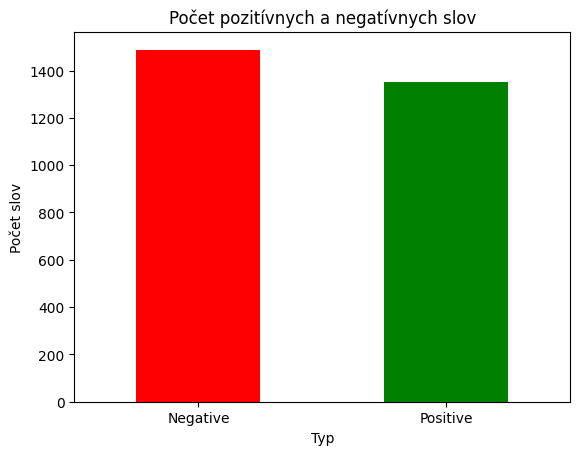

In [107]:
label_counts = df['label'].value_counts()

label_counts.index = ['Negative', 'Positive']

label_counts.plot(kind='bar', color=['red', 'green'])

plt.title('Počet pozitívnych a negatívnych slov')
plt.xlabel('Typ')
plt.ylabel('Počet slov')
plt.xticks(rotation=0)
plt.show()

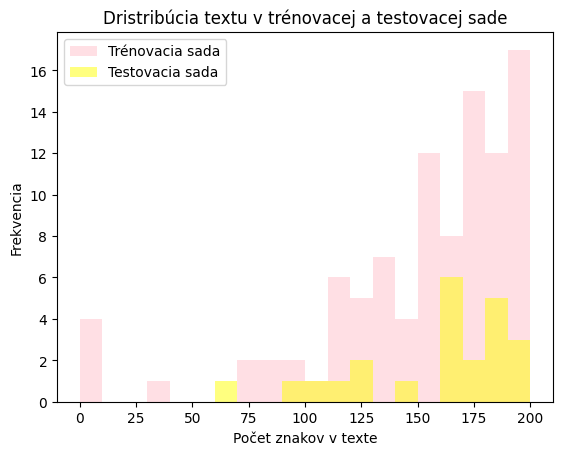

In [108]:
train_lengths = df['text'].str.len()
test_lengths = test_df['text'].str.len()

plt.hist(train_lengths, bins=range(0, 201, 10), color='pink', label='Trénovacia sada', alpha=0.5)

plt.hist(test_lengths, bins=range(0, 201, 10), color='yellow', label='Testovacia sada', alpha=0.5)

plt.title('Dristribúcia textu v trénovacej a testovacej sade')
plt.xlabel('Počet znakov v texte')
plt.ylabel('Frekvencia')
plt.legend()

plt.show()

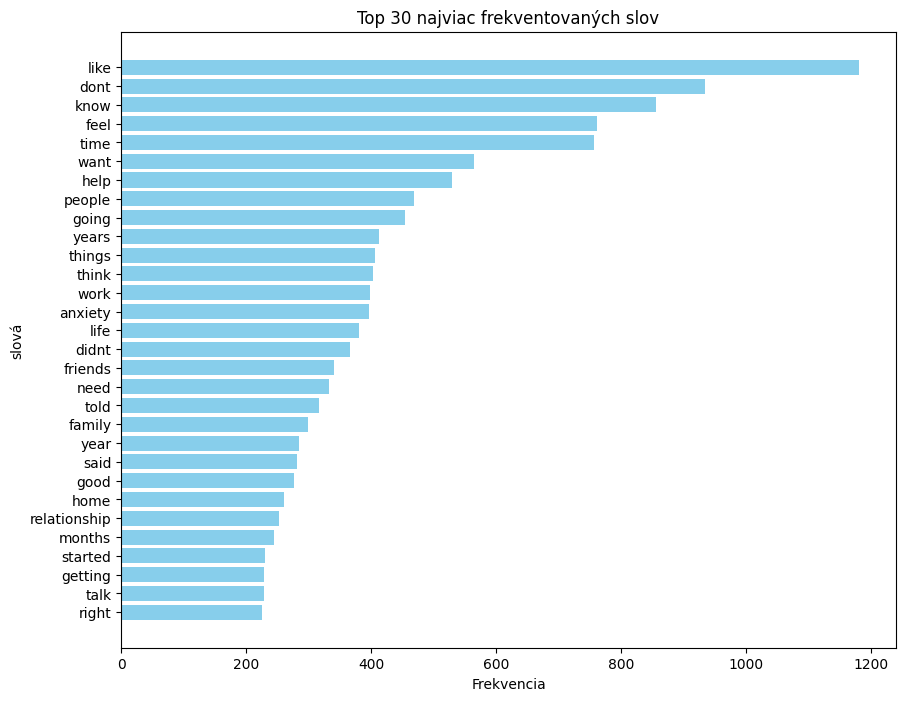

In [109]:
words_df = pd.DataFrame(most_common_words, columns=['Word', 'Frequency'])

words_df.sort_values(by='Frequency', ascending=True, inplace=True)

plt.figure(figsize=(10, 8))

plt.barh(words_df['Word'], words_df['Frequency'], color='skyblue')
plt.xlabel('Frekvencia')
plt.ylabel('slová')
plt.title('Top 30 najviac frekventovaných slov')
plt.show()

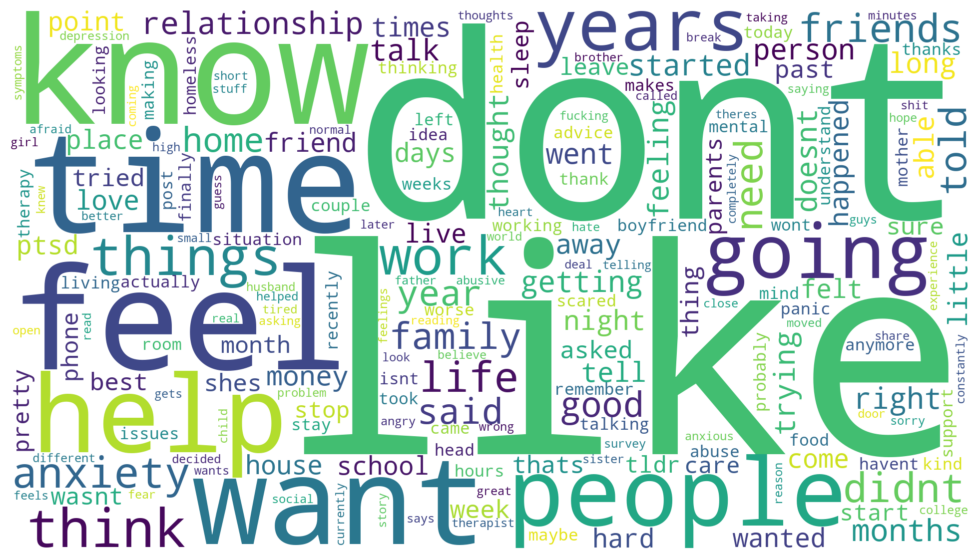

In [5]:
# Create and display the word cloud for the training set
wordcloud = WordCloud(width=1920, height=1080, background_color='white').generate_from_frequencies(word_counts)
plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

<p style="font-size:24px;">Tematické modelovanie LDA</p>

In [110]:
# Create a dictionary and corpus
dictionary = corpora.Dictionary(df['processed_text'])
corpus = [dictionary.doc2bow(text) for text in df['processed_text']]

In [111]:
import gensim
# Train LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus, num_topics=10, id2word=dictionary, passes=15)

In [112]:
# Get the topics
topic_df = pd.DataFrame()

In [113]:
# Display the topics similar to the image provided
for i, topic in lda_model.show_topics(formatted=False, num_topics=10, num_words=20):
    topic_words = dict(topic)
    topic_df = pd.concat([topic_df, pd.DataFrame({'Topic_' + str(i): list(topic_words.keys()), 'Weight_' + str(i): list(topic_words.values())})], axis=1)

In [114]:
print(topic_df)

        Topic_0  Weight_0  Topic_1  Weight_1  Topic_2  Weight_2  Topic_3  \
0        survey  0.019203     time  0.012565     like  0.028793  anxiety   
1     treatment  0.014148    years  0.007031     feel  0.022558    going   
2         thank  0.013596   family  0.006747     dont  0.021831    didnt   
3          time  0.013152    going  0.006637     know  0.018600     said   
4      complete  0.008705     year  0.005944     want  0.012847     like   
5          help  0.007409     work  0.005775     time  0.010119    night   
6      research  0.006590     home  0.005763     help  0.009703     dont   
7         study  0.006242     like  0.005689    think  0.008416     time   
8          link  0.005987    didnt  0.005338   things  0.007897    years   
9   preferences  0.005794    house  0.004949     life  0.007317   family   
10  information  0.005771  getting  0.004734   doesnt  0.006688   issues   
11      reading  0.005606   wanted  0.004337     need  0.006471     door   
12        it

In [116]:
styled_df = topic_df.style.background_gradient()

In [117]:
topic_df.to_excel('lda_topics.xlsx', index=False)

In [118]:
from gensim.corpora import Dictionary

processed_docs = df['processed_text'].tolist()

# Create a dictionary representation of the documents
dictionary = Dictionary(processed_docs)

# Filter out extremes to limit the number of features
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

# Create a bag-of-words representation of the documents
corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

In [119]:
num_topics = 10
passes = 10
random_state = 100

# Train the LDA model
lda_model = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary, passes=passes, random_state=random_state)

In [120]:
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

# Prepare visualization
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, dictionary)

# Visualize
pyLDAvis.display(vis)

C:\Users\patri\AppData\Roaming\Python\Python312\site-packages\joblib\_utils.py:38: DeprecationWarning: ast.Num is deprecated and will be removed in Python 3.14; use ast.Constant instead
  if isinstance(node, ast.Num):  # <number>
C:\Users\patri\AppData\Roaming\Python\Python312\site-packages\joblib\_utils.py:38: DeprecationWarning: ast.Num is deprecated and will be removed in Python 3.14; use ast.Constant instead
  if isinstance(node, ast.Num):  # <number>
C:\Users\patri\AppData\Roaming\Python\Python312\site-packages\joblib\_utils.py:39: DeprecationWarning: Attribute n is deprecated and will be removed in Python 3.14; use value instead
  return node.n
C:\Users\patri\AppData\Roaming\Python\Python312\site-packages\joblib\_utils.py:38: DeprecationWarning: ast.Num is deprecated and will be removed in Python 3.14; use ast.Constant instead
  if isinstance(node, ast.Num):  # <number>
C:\Users\patri\AppData\Roaming\Python\Python312\site-packages\joblib\_utils.py:39: DeprecationWarning: Attribut

In [121]:
pyLDAvis.save_html(vis, 'lda_vizualizácia.html')

<p style="font-size:24px;">Binárne klasifikátory</p>

In [122]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Join tokens back to form strings
df['joined_processed_text'] = df['processed_text'].apply(lambda x: ' '.join(x))
test_df['joined_processed_text'] = test_df['processed_text'].apply(lambda x: ' '.join(x))

# Initialize a TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000)

# Fit and transform the processed text
X_train = tfidf_vectorizer.fit_transform(df['joined_processed_text']).toarray()
X_test = tfidf_vectorizer.transform(test_df['joined_processed_text']).toarray()

y_train = df['label'].values
y_test = test_df['label'].values

Logistic Regression

In [123]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

# Making predictions
log_reg_preds = log_reg.predict(X_test)

# Evaluating the model
print("Logistic Regression Accuracy:", accuracy_score(y_test, log_reg_preds))
print("Classification Report:\n", classification_report(y_test, log_reg_preds))

Logistic Regression Accuracy: 0.7258741258741259
Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.66      0.70       346
           1       0.71      0.79      0.75       369

    accuracy                           0.73       715
   macro avg       0.73      0.72      0.72       715
weighted avg       0.73      0.73      0.72       715



Decision Tree

In [124]:
from sklearn.tree import DecisionTreeClassifier

decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, y_train)

# Making predictions
dt_preds = decision_tree.predict(X_test)

# Evaluating the model
print("Decision Tree Accuracy:", accuracy_score(y_test, dt_preds))
print("Classification Report:\n", classification_report(y_test, dt_preds))

Decision Tree Accuracy: 0.5454545454545454
Classification Report:
               precision    recall  f1-score   support

           0       0.53      0.47      0.50       346
           1       0.55      0.62      0.58       369

    accuracy                           0.55       715
   macro avg       0.54      0.54      0.54       715
weighted avg       0.54      0.55      0.54       715



Random Forest

In [125]:
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier(n_estimators=500)
random_forest.fit(X_train, y_train)

# Making predictions
rf_preds = random_forest.predict(X_test)

# Evaluating the model
print("Random Forest Accuracy:", accuracy_score(y_test, rf_preds))
print("Classification Report:\n", classification_report(y_test, rf_preds))

Random Forest Accuracy: 0.6727272727272727
Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.48      0.59       346
           1       0.64      0.85      0.73       369

    accuracy                           0.67       715
   macro avg       0.70      0.67      0.66       715
weighted avg       0.69      0.67      0.66       715



<p style="font-size:24px;">Porovnanie binárnych modelov</p>

In [126]:
from sklearn.metrics import precision_recall_fscore_support

precision_lr, recall_lr, f1_lr, _ = precision_recall_fscore_support(y_test, log_reg_preds, average='binary')

precision_dt, recall_dt, f1_dt, _ = precision_recall_fscore_support(y_test, dt_preds, average='binary')
precision_rf, recall_rf, f1_rf, _ = precision_recall_fscore_support(y_test, rf_preds, average='binary')

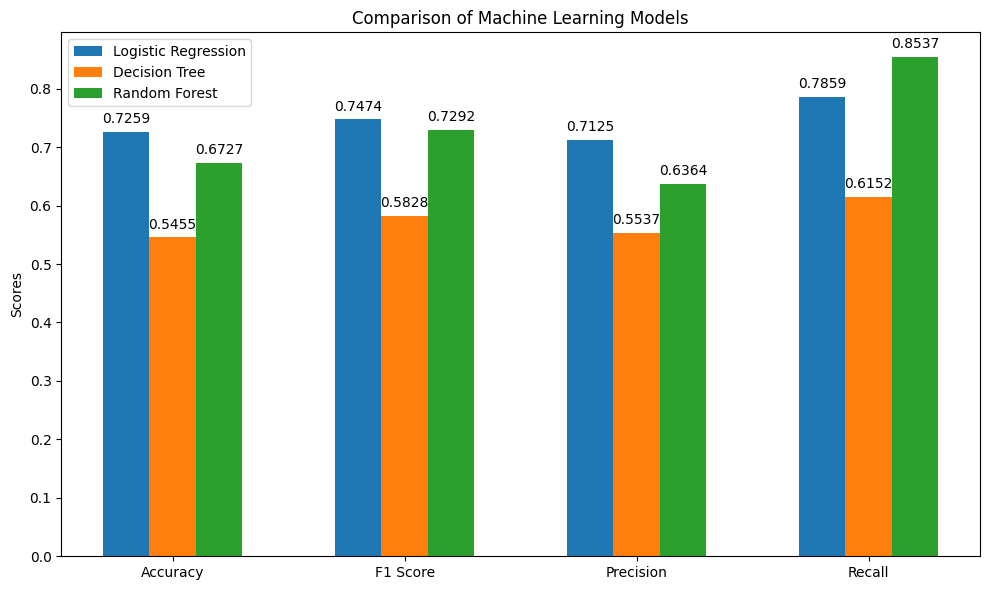

In [127]:
log_reg_acc = accuracy_score(y_test, log_reg_preds)
dt_acc = accuracy_score(y_test, dt_preds)
rf_acc = accuracy_score(y_test, rf_preds)

# Create a DataFrame structure similar to the provided data
data = {
    'Metrics': ['Accuracy', 'F1 Score', 'Precision', 'Recall'],
    'Logistic Regression': [log_reg_acc, f1_lr, precision_lr, recall_lr],
    'Decision Tree': [dt_acc, f1_dt, precision_dt, recall_dt],
    'Random Forest': [rf_acc, f1_rf, precision_rf, recall_rf]
}

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
# We'll need this bar location list to properly position our bars
bar_locations = np.arange(len(data['Metrics']))
# We'll need this width when plotting our bars side-by-side
width = 0.2

# Plotting each model's metrics
ax.bar(bar_locations - width, data['Logistic Regression'], width=width, label='Logistic Regression')
ax.bar(bar_locations, data['Decision Tree'], width=width, label='Decision Tree')
ax.bar(bar_locations + width, data['Random Forest'], width=width, label='Random Forest')

# Annotating the bar plot with the actual values
for i in range(len(data['Metrics'])):
    ax.text(i - width, data['Logistic Regression'][i] + 0.01, f'{data["Logistic Regression"][i]:.4f}', ha='center', va='bottom')
    ax.text(i, data['Decision Tree'][i] + 0.01, f'{data["Decision Tree"][i]:.4f}', ha='center', va='bottom')
    ax.text(i + width, data['Random Forest'][i] + 0.01, f'{data["Random Forest"][i]:.4f}', ha='center', va='bottom')

# Setting the labels and title
ax.set_xticks(bar_locations)
ax.set_xticklabels(data['Metrics'])
ax.set_ylabel('Scores')
ax.set_title('Comparison of Machine Learning Models')

# Add the legend and show the plot
ax.legend()
plt.tight_layout()
plt.show()


Testovanie Logistickej Regresie

In [128]:
new_data = ["feeling bad", "good life"]

# Preprocess the new data
new_data_processed = [' '.join(preprocess(text)) for text in new_data]

# Transform the new data using the existing TfidfVectorizer
new_data_transformed = tfidf_vectorizer.transform(new_data_processed).toarray()

# Make predictions using the logistic regression model
new_data_predictions = log_reg.predict(new_data_transformed)

# Output predictions
for text, prediction in zip(new_data, new_data_predictions):
    print(f"Post: {text}")
    print(f"Predicted Sentiment: {'Negative' if prediction == 1 else 'Positive'}\n")

Post: feeling bad
Predicted Sentiment: Negative

Post: good life
Predicted Sentiment: Positive



<p style="font-size:24px;">BERT Training Model</p>


In [3]:
from transformers import BertTokenizer
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(df, test_size=0.2)

# Initialize the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the text for BERT
train_encodings = tokenizer(train_df['text'].tolist(), truncation=True, padding='max_length', max_length=128)
val_encodings = tokenizer(val_df['text'].tolist(), truncation=True, padding='max_length', max_length=128)

C:\Users\patri\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from torch.utils.data import Dataset, DataLoader
import torch

class StressDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Convert dataframes to datasets
train_dataset = StressDataset(train_encodings, train_df['label'].tolist())
val_dataset = StressDataset(val_encodings, val_df['label'].tolist())

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

In [6]:
from transformers import BertForSequenceClassification, get_linear_schedule_with_warmup
from torch.optim import AdamW
import torch
from sklearn.metrics import accuracy_score
import numpy as np
import os
from tqdm.auto import tqdm

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [131]:
optimizer = AdamW(model.parameters(), lr=5e-5)
epochs = 4
total_steps = len(train_loader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

def evaluate_model(model, val_loader):
    model.eval()
    eval_accuracy = 0
    eval_loss = 0
    preds = []
    true_labels = []
    
    progress_bar = tqdm(val_loader, desc="Validation", leave=False)
    
    for batch in progress_bar:
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)

        logits = outputs.logits
        preds.append(torch.argmax(logits, dim=-1).cpu().numpy())
        true_labels.append(batch['labels'].cpu().numpy())
        eval_loss += outputs.loss.mean().item()

    eval_preds = np.concatenate(preds, axis=0)
    eval_labels = np.concatenate(true_labels, axis=0)
    accuracy = accuracy_score(eval_labels, eval_preds)
    eval_loss = eval_loss / len(val_loader)
    return accuracy, eval_loss

for epoch in range(epochs):
    model.train()
    total_loss = 0
    
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs}", leave=False)
    
    for batch in progress_bar:
        batch = {k: v.to(device) for k, v in batch.items()}
        model.zero_grad()
        outputs = model(**batch)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

        progress_bar.set_postfix({'loss': f"{loss.item():.4f}"})

    avg_train_loss = total_loss / len(train_loader)
    accuracy, avg_val_loss = evaluate_model(model, val_loader)
    
    print(f"Epoch {epoch + 1}/{epochs} | Training loss: {avg_train_loss:.4f} | Validation Loss: {avg_val_loss:.4f} | Accuracy: {accuracy:.4f}")

    if not os.path.exists('model_save'):
        os.makedirs('model_save')
    torch.save(model.state_dict(), 'model_save/bert_model.pt')

print("Training complete.")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/4 | Training loss: 0.5056 | Validation Loss: 0.5101 | Accuracy: 0.7236


Epoch 2/4 | Training loss: 0.2888 | Validation Loss: 0.5331 | Accuracy: 0.7923


Epoch 3/4 | Training loss: 0.1186 | Validation Loss: 0.8409 | Accuracy: 0.7958


Epoch 4/4 | Training loss: 0.0278 | Validation Loss: 0.9864 | Accuracy: 0.8028
Training complete.


<p style="font-size:24px;">BERT Testing Model</p>

In [132]:
import pandas as pd
from transformers import BertTokenizer
from torch.utils.data import DataLoader, Dataset
import torch

# Load the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the text
test_encodings = tokenizer(test_df['text'].tolist(), truncation=True, padding=True, max_length=128, return_tensors="pt")

In [133]:
class CustomDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Create the test dataset
test_dataset = CustomDataset(test_encodings, test_df['label'].tolist())

In [134]:
# Create the DataLoader for our test set
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [135]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import numpy as np

# Load the model
model = BertForSequenceClassification.from_pretrained('./model_save')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Evaluate the model
model.eval()
predictions, bert_labels = [], []

with torch.no_grad():
    for batch in test_loader:
        inputs = {key: val.to(device) for key, val in batch.items() if key != 'labels'}
        labels = batch['labels'].to(device)
        outputs = model(**inputs)
        
        logits = outputs.logits
        preds = torch.argmax(logits, dim=-1)
        
        predictions.extend(preds.cpu().numpy())
        bert_labels.extend(labels.cpu().numpy())

# Calculate evaluation metrics
precision, recall, f1, _ = precision_recall_fscore_support(bert_labels, predictions, average='binary')
accuracy = accuracy_score(bert_labels, predictions)

print(f'BERT Accuracy: {accuracy:.4f}')
print(f'BERT Precision: {precision:.4f}')
print(f'BERT Recall: {recall:.4f}')
print(f'BERT F1 Score: {f1:.4f}')

BERT Accuracy: 0.7748
BERT Precision: 0.7955
BERT Recall: 0.7588
BERT F1 Score: 0.7767


In [8]:
def predict_stress(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs.to(model.device))
    prediction = torch.argmax(outputs.logits, dim=-1).item()
    return "Stress" if prediction == 1 else "No Stress"

sentence = "I am feeling really bad"
print(predict_stress(sentence))

Stress


In [140]:
model.save_pretrained('./model_save')
tokenizer.save_pretrained('./model_save')

('./model_save\\tokenizer_config.json',
 './model_save\\special_tokens_map.json',
 './model_save\\vocab.txt',
 './model_save\\added_tokens.json')